# Capture the Flag (RL - Policy Gradient)

- Seung Hyun Kim
- skim449@illinois.edu

## Notes
- This notebook includes:
    - Building the structure of policy driven network.
    - Training with/without render
    - Saver that save model and weights to ./model directory
    - Writer that will record some necessary datas to ./logs
- This notebook does not include running the CtF game with the RL policy. Using the network will be separately scripted in policy/policy_RL1.py.
    - cap_test.py is changed appropriately.
    
## References :
- https://github.com/awjuliani/DeepRL-Agents/blob/master/Vanilla-Policy.ipynb (source)
- https://www.youtube.com/watch?v=PDbXPBwOavc

In [1]:
TRAIN_NAME='NO_RED_03_MULTI'
LOG_PATH='./logs/' + TRAIN_NAME
MODEL_PATH='./model/' + TRAIN_NAME
GPU_CAPACITY=0.33 # gpu capacity in percentage

In [2]:
import os

import time
import threading
from threading import Thread
import multiprocessing as mp
from multiprocessing import Process, Pool
#mp.set_start_method('spawn')

import tensorflow as tf
import tensorflow.contrib.slim as slim
import matplotlib.pyplot as plt
%matplotlib inline

import gym
import gym_cap
import gym_cap.envs.const as CONST
import numpy as np
import random

# the modules that you can use to generate the policy.
import policy.patrol 
import policy.random
import policy.simple # custon written policy
import policy.policy_RL
import policy.zeros

# Data Processing Module
from DataModule import one_hot_encoder, VISION_dX, VISION_dY

pygame 1.9.4
Hello from the pygame community. https://www.pygame.org/contribute.html


## Environment Setting

In [3]:
dummy_env = gym.make("cap-v0") # initialize the environment
policy_red = policy.random.PolicyGen(dummy_env.get_map, dummy_env.get_team_red)
  
print('red number : ', len(dummy_env.get_team_red))
print('blue number : ', len(dummy_env.get_team_blue))

red number :  0
blue number :  4


In [4]:
if not os.path.exists(MODEL_PATH):
    os.makedirs(MODEL_PATH)
    
#Create a directory to save episode
if not os.path.exists(LOG_PATH):
    os.makedirs(LOG_PATH)

## Discount Reward

In [5]:
gamma = 0.98

def discount_rewards(r, pre_discount=0):
    """ take 1D float array of rewards and compute discounted reward """
    discounted_r = np.zeros_like(r)
    running_add = 0.0
    pre_disc_factor = gamma**pre_discount
    for t in reversed(range(r.size)):
        running_add = (running_add * gamma + r[t]) * pre_disc_factor
        discounted_r[t] = running_add
    discounted_r = (discounted_r - np.mean(discounted_r)) / (np.std(discounted_r)+1e-8) # normalize
    return discounted_r

def discount_rewards_multiagent(r, n_agents):
    discounted_r = np.reshape(r,(-1,n_agents)) # Reshape the r into vertical matrix with 'n_agents' columns
    for idx in range(n_agents):
        column = discounted_r[:,idx]                     # extract single column
        discounted_r[:,idx] = discount_rewards(column);  # Run discount_reward on the column, and substitute
    return np.reshape(discounted_r,(-1))                 # return the flattened matrix

## Network Setting

In [6]:
class agent():
    def __init__(self, lr, in_size,action_size):
        #These lines established the feed-forward part of the network. The agent takes a state and produces an action.
        self.state_input = tf.placeholder(shape=in_size,dtype=tf.float32, name='state')
        
        layer = slim.conv2d(self.state_input, 16, [5,5], activation_fn=tf.nn.relu,
                            padding='SAME',
                            scope='conv1')
        #layer = slim.avg_pool2d(layer, [2,2])
        layer = slim.conv2d(layer, 16, [3,3], activation_fn=tf.nn.relu,
                            padding='SAME',
                            scope='conv2')
        layer = slim.flatten(layer)
        #flat  = tf.reshape(conv, [-1, VISION_dX*VISION_dY*128])
        #layer = slim.dropout(layer,keep_prob=0.8)
        #layer = slim.fully_connected(layer, 516,
        #                            activation_fn=tf.nn.relu,
        #                            biases_initializer=None,
        #                            scope='hidden_fc1')
        layer = slim.dropout(layer,keep_prob=0.8)
        #layer = slim.fully_connected(layer, 516,
        #                            #activation_fn=tf.nn.relu,
        #                            biases_initializer=None)
        self.dense = slim.fully_connected(layer, action_size,
                                     activation_fn=tf.nn.relu,
                                     biases_initializer=None,
                                     scope='output_fc')
        self.output = tf.nn.softmax(self.dense, name='action')
        
        tf.summary.histogram('output', self.output)
        
        with tf.name_scope('weights'):
            for var in slim.get_model_variables():
                tf.summary.histogram(var.op.name, var)

        #The next six lines establish the training proceedure. We feed the reward and chosen action into the network
        #to compute the loss, and use it to update the network.

        with tf.name_scope('loss'):
            self.action_holder = tf.placeholder(tf.int32, [None, action_size])
            self.reward_holder = tf.placeholder(tf.float32, [None])
            self.neg_log_prob = tf.nn.softmax_cross_entropy_with_logits_v2(logits = self.dense, labels = self.action_holder)
            self.loss = -tf.reduce_mean(self.neg_log_prob * self.reward_holder) 
            tf.summary.scalar('loss', self.loss)

        with tf.name_scope('optimizer'):
            #optimizer = tf.train.AdamOptimizer(learning_rate=lr)
            #self.update_batch = optimizer.apply_gradients(zip(self.gradient_holders,tvars))
            self.update_batch = tf.train.RMSPropOptimizer(learning_rate=lr).minimize(self.loss)

In [7]:
tf.reset_default_graph() # Clear the Tensorflow graph.
myAgent = agent(lr=1e-5,in_size=[None,VISION_dX,VISION_dY,6],action_size=5) #Load the agent.
global_step = tf.Variable(0, trainable=False, name='global_step') # global step
increment_global_step_op = tf.assign(global_step, global_step+1)
merged = tf.summary.merge_all()

## Hyperparameters

In [8]:
# Training Related
total_episodes = 10000 #Set total number of episodes to train agent on.
max_ep = 150
update_frequency = 5
batch_size = 1000 # should be around max_ep * update frequency

# Saving Related
save_network_frequency = 100
save_stat_frequency = 50
moving_average_step = 50

# Environment Related
action_space = 5
n_agent = len(dummy_env.get_team_blue)

## Session

In [9]:
# Launch the session
# Launch the session
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=GPU_CAPACITY)

sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))
#sess = tf.Session()

local_episode = 0
total_reward = []
total_length = []
total_captured = []

# Setup Save and Restore Network
saver = tf.train.Saver(tf.global_variables())
writer = tf.summary.FileWriter(LOG_PATH, sess.graph)

ckpt = tf.train.get_checkpoint_state(MODEL_PATH)
if ckpt and tf.train.checkpoint_exists(ckpt.model_checkpoint_path):
    saver.restore(sess, ckpt.model_checkpoint_path)
    print("Load Model : ", ckpt.model_checkpoint_path)
else:
    sess.run(tf.global_variables_initializer())
    print("Initialized Variables")

INFO:tensorflow:Restoring parameters from ./model/NO_RED_02_MULTI/ctf_policy.ckpt-1
Load Model :  ./model/NO_RED_02_MULTI/ctf_policy.ckpt-1


In [10]:
def record(episode_count):
    with tf.device('/cpu:0'): 
        summary = tf.Summary()
        summary.value.add(tag='Record/mean_reward', simple_value=np.mean(total_length[-moving_average_step:]))
        summary.value.add(tag='Record/mean_length', simple_value=np.mean(total_reward[-moving_average_step:]))
        summary.value.add(tag='Record/mean_succeed', simple_value=np.mean(total_captured[-moving_average_step:]))
        writer.add_summary(summary, episode_count)
        
        '''summary_str = sess.run(merged,
                        feed_dict={myAgent.state_input:one_hot_encoder(dummy_env._env, dummy_env.get_team_blue)})
        writer.add_summary(summary_str, episode_count)'''
        
        writer.flush()

## Experience Replay Buffer

In [11]:
class Experience_buffer:
    def __init__(self, buffer_size = 50000):
        self.buffer = []
        self.buffer_size = buffer_size
    
    def add(self,experience):
        if len(self.buffer) + len(experience) >= self.buffer_size:
            self.buffer[0:(len(experience)+len(self.buffer))-self.buffer_size] = []
        self.buffer.extend(experience)
            
    def sample(self, size=2000):
        if size > len(self.buffer):
            return np.array(self.buffer)
        else:
            return np.reshape(np.array(random.sample(self.buffer,size)),[size,3])

In [12]:
exp_buffer = Experience_buffer()

## Environment

- Each agent will have separate environment to play, and it will play the game on its own.

In [ ]:
class Worker():
    def __init__(self,game,name,s_size,a_size,trainer,model_path,global_episodes):
        self.name = "worker_" + str(name)
        self.number = name        
        self.model_path = model_path
        self.trainer = trainer
        self.global_episodes = global_episodes
        self.increment = self.global_episodes.assign_add(1)
        self.episode_rewards = []
        self.episode_lengths = []
        self.episode_mean_values = []
        self.summary_writer = tf.summary.FileWriter("train_"+str(self.number))

        #Create the local copy of the network and the tensorflow op to copy global paramters to local network
        self.local_AC = AC_Network(s_size,a_size,self.name,trainer)
        self.update_local_ops = update_target_graph('global',self.name)        
        
    def train(self,rollout,sess,gamma,bootstrap_value):
        rollout = np.array(rollout)
        observations = rollout[:,0]
        actions = rollout[:,1]
        rewards = rollout[:,2]
        next_observations = rollout[:,3]
        values = rollout[:,5]
        
        # Here we take the rewards and values from the rollout, and use them to 
        # generate the advantage and discounted returns. 
        # The advantage function uses "Generalized Advantage Estimation"
        self.rewards_plus = np.asarray(rewards.tolist() + [bootstrap_value])
        discounted_rewards = discount(self.rewards_plus,gamma)[:-1]
        self.value_plus = np.asarray(values.tolist() + [bootstrap_value])
        advantages = rewards + gamma * self.value_plus[1:] - self.value_plus[:-1]
        advantages = discount(advantages,gamma)

        # Update the global network using gradients from loss
        # Generate network statistics to periodically save
        feed_dict = {self.local_AC.target_v:discounted_rewards,
            self.local_AC.inputs:np.vstack(observations),
            self.local_AC.actions:actions,
            self.local_AC.advantages:advantages,
            self.local_AC.state_in[0]:self.batch_rnn_state[0],
            self.local_AC.state_in[1]:self.batch_rnn_state[1]}
        v_l,p_l,e_l,g_n,v_n, self.batch_rnn_state,_ = sess.run([self.local_AC.value_loss,
            self.local_AC.policy_loss,
            self.local_AC.entropy,
            self.local_AC.grad_norms,
            self.local_AC.var_norms,
            self.local_AC.state_out,
            self.local_AC.apply_grads],
            feed_dict=feed_dict)
        return v_l / len(rollout),p_l / len(rollout),e_l / len(rollout), g_n,v_n
        
    def work(self,max_episode_length,gamma,sess,coord,saver):
        episode_count = sess.run(self.global_episodes)
        total_steps = 0
        print ("Starting worker " + str(self.number))
        with sess.as_default(), sess.graph.as_default():                 
            while not coord.should_stop():
                sess.run(self.update_local_ops)
                episode_buffer = []
                episode_values = []
                episode_frames = []
                episode_reward = 0
                episode_step_count = 0
                d = False
                
                self.env.new_episode()
                s = self.env.get_state().screen_buffer
                episode_frames.append(s)
                s = process_frame(s)
                rnn_state = self.local_AC.state_init
                self.batch_rnn_state = rnn_state
                while self.env.is_episode_finished() == False:
                    #Take an action using probabilities from policy network output.
                    a_dist,v,rnn_state = sess.run([self.local_AC.policy,self.local_AC.value,self.local_AC.state_out], 
                        feed_dict={self.local_AC.inputs:[s],
                        self.local_AC.state_in[0]:rnn_state[0],
                        self.local_AC.state_in[1]:rnn_state[1]})
                    a = np.random.choice(a_dist[0],p=a_dist[0])
                    a = np.argmax(a_dist == a)

                    r = self.env.make_action(self.actions[a]) / 100.0
                    d = self.env.is_episode_finished()
                    if d == False:
                        s1 = self.env.get_state().screen_buffer
                        episode_frames.append(s1)
                        s1 = process_frame(s1)
                    else:
                        s1 = s
                        
                    episode_buffer.append([s,a,r,s1,d,v[0,0]])
                    episode_values.append(v[0,0])

                    episode_reward += r
                    s = s1                    
                    total_steps += 1
                    episode_step_count += 1
                    
                    # If the episode hasn't ended, but the experience buffer is full, then we
                    # make an update step using that experience rollout.
                    if len(episode_buffer) == 30 and d != True and episode_step_count != max_episode_length - 1:
                        # Since we don't know what the true final return is, we "bootstrap" from our current
                        # value estimation.
                        v1 = sess.run(self.local_AC.value, 
                            feed_dict={self.local_AC.inputs:[s],
                            self.local_AC.state_in[0]:rnn_state[0],
                            self.local_AC.state_in[1]:rnn_state[1]})[0,0]
                        v_l,p_l,e_l,g_n,v_n = self.train(episode_buffer,sess,gamma,v1)
                        episode_buffer = []
                        sess.run(self.update_local_ops)
                    if d == True:
                        break
                                            
                self.episode_rewards.append(episode_reward)
                self.episode_lengths.append(episode_step_count)
                self.episode_mean_values.append(np.mean(episode_values))
                
                # Update the network using the episode buffer at the end of the episode.
                if len(episode_buffer) != 0:
                    v_l,p_l,e_l,g_n,v_n = self.train(episode_buffer,sess,gamma,0.0)
                                
                    
                # Periodically save gifs of episodes, model parameters, and summary statistics.
                if episode_count % 5 == 0 and episode_count != 0:
                    if self.name == 'worker_0' and episode_count % 25 == 0:
                        time_per_step = 0.05
                        images = np.array(episode_frames)
                        make_gif(images,'./frames/image'+str(episode_count)+'.gif',
                            duration=len(images)*time_per_step,true_image=True,salience=False)
                    if episode_count % 250 == 0 and self.name == 'worker_0':
                        saver.save(sess,self.model_path+'/model-'+str(episode_count)+'.cptk')
                        print ("Saved Model")

                    mean_reward = np.mean(self.episode_rewards[-5:])
                    mean_length = np.mean(self.episode_lengths[-5:])
                    mean_value = np.mean(self.episode_mean_values[-5:])
                    summary = tf.Summary()
                    summary.value.add(tag='Perf/Reward', simple_value=float(mean_reward))
                    summary.value.add(tag='Perf/Length', simple_value=float(mean_length))
                    summary.value.add(tag='Perf/Value', simple_value=float(mean_value))
                    summary.value.add(tag='Losses/Value Loss', simple_value=float(v_l))
                    summary.value.add(tag='Losses/Policy Loss', simple_value=float(p_l))
                    summary.value.add(tag='Losses/Entropy', simple_value=float(e_l))
                    summary.value.add(tag='Losses/Grad Norm', simple_value=float(g_n))
                    summary.value.add(tag='Losses/Var Norm', simple_value=float(v_n))
                    self.summary_writer.add_summary(summary, episode_count)

                    self.summary_writer.flush()
                if self.name == 'worker_0':
                    sess.run(self.increment)
                episode_count += 1

In [30]:
class Environment(Process):
    def __init__(self, i):
        Process.__init__(self)
        self.env = gym.make("cap-v0") # initialize the environment
        self.policy_red = policy.random.PolicyGen(self.env.get_map, self.env.get_team_red)
        self.blue_team = self.env.get_team_blue
        self.nBlue = len(self.blue_team)
    
    def rollout(self):
        s = self.env.reset(map_size=20, policy_red=self.policy_red)

        ep_history = []
        indv_history = [[] for _ in range(self.nBlue)]

        was_alive = [ag.isAlive for ag in self.blue_team]
        prev_reward=0
        for frame in range(max_ep+1):
            #obs = one_hot_encoder(s, env.get_team_blue).tolist() # partial observation
            obs = one_hot_encoder(self.env._env, self.blue_team) # Full observation

            with tf.device('/cpu:0'):
                #Probabilistically pick an action given our network outputs.
                act_prob = sess.run(myAgent.output, feed_dict={myAgent.state_input:obs})
                act = [np.random.choice(action_space, p=act_prob[x]/sum(act_prob[x])) for x in range(self.nBlue)] # divide by sum : normalize

            s,r,d,_ = self.env.step(act) #Get our reward for taking an action given a bandit.

            # If frame is at max and the game is still not done, negative reward
            if frame == max_ep and d == False:
                r -= frame * (30/150)
                #r -= 30

            # Push history for individual that 'was' alive previous frame
            for idx, agent in enumerate(self.blue_team):
                if was_alive[idx]: indv_history[idx].append([obs[idx],act[idx],r])

            # If reward sequence change, push the history into the episode history.
            if prev_reward != r:
                for idx, history in enumerate(indv_history):
                    if len(history)==0: continue
                    if not was_alive[idx]: continue
                    _history = np.array(history)
                    _history[:,2] = discount_rewards(_history[:,2])
                    ep_history.extend(_history)

            # State Transition
            frame += 1
            prev_reward = r
            was_alive = [ag.isAlive for ag in self.blue_team]

            if d == True:
                break

        if len(ep_history) > 0:        
            ep_history = np.stack(ep_history)

        total_reward.append(r)
        total_length.append(frame)
        total_captured.append(self.env.game_won)    
            
        return ep_history

    
    def run(self, coord, progbar):
        global local_episode
        # Run episode
        while not coord.should_stop():
            print(local_episode)
            sess.run(increment_global_step_op)
            episode_number = local_episode

            print(episode_number)
            local_episode += 1
            progbar.update(episode_number)

            if episode_number > total_episodes+1:
                break
            
            ep_history = self.rollout() # play single episode
            
            exp_buffer.add(ep_history)
            
            # save statistics
            if episode_number % save_stat_frequency == 0 and episode_number != 0:
                record(episode_number)

            # save network weights
            if episode_number % save_network_frequency == 0 and episode_number != 0:
                saver.save(sess, MODEL_PATH+'/ctf_policy.ckpt', global_step=global_step)
                print("save weights: ", sess.run(global_step), 'episodes')

## Trainer

In [28]:
class Trainer(Process):
    def __init__(self, exp_buffer):
        Process.__init__(self)
        self.exp_buffer = exp_buffer
    
    def run(self, coord):
        global local_episode
        # Run single training sequence
        counter = update_frequency
        while not coord.should_stop():
            time.sleep(0.5)
            if local_episode > total_episodes+1:
                break
            if local_episode > counter:
                print('training at: ', local_episode)
                counter += update_frequency
                with tf.device('/gpu:0'):
                    batch_history = exp_buffer.sample(batch_size) # Sample from experience replay
                    feed_dict = {myAgent.state_input: np.stack(batch_history[:,0]),
                                                myAgent.action_holder:sess.run(tf.one_hot(batch_history[:,1],5)),
                                                myAgent.reward_holder: batch_history[:,2]}
                    loss_, _ = sess.run([myAgent.loss, myAgent.update_batch],
                                        feed_dict=feed_dict)
        return loss_

## Training

process setup start
    No. 0  environment initialized
    No. 1  environment initialized
    No. 2  environment initialized
    No. 3  environment initialized
    No. 4  environment initialized
Training Starts
process setup done
0
0
0
0
0


Process Process-66:
Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-28-3d6a100af943>", line 11, in run
    time.sleep(0.5)
KeyboardInterrupt




Manually stopped the training (KeyboardInterrupt)
save:  1 episodes


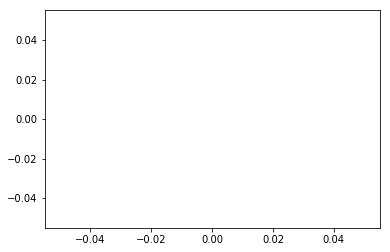

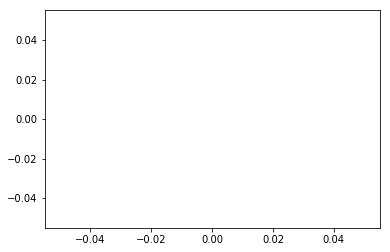

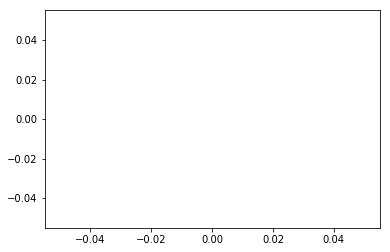

In [31]:
if __name__ == '__main__':
    ep = 0
    progbar = tf.keras.utils.Progbar(total_episodes,width=5)
    
    # Setup experience buffer
    exp_buffer = Experience_buffer()
    
    # Define multiprocessing coordinate and threads
    print('process setup start')
    coord = tf.train.Coordinator()
    num_environment = min(update_frequency,mp.cpu_count())
    environments = []
    for i in range(num_environment):
        environments.append(Environment(i))
        print('    No.',i,' environment initialized')
    
    try:
        training_begin_time = time.time()
        # Multiprocess environment
        print('Training Starts')
        trainer = Trainer(exp_buffer)
        process_rollouts = [Process(target=env_.run, args=[coord, progbar]) for env_ in environments]
        process_rollouts.append(Process(target=trainer.run, args=[coord]))
        print('process setup done')
        for process in process_rollouts:
            process.start()
            time.sleep(0.5)
        coord.join(process_rollouts)

        print('Training finished ', time.time() - training_begin_time,'sec')

    except KeyboardInterrupt:
        print('\n\nManually stopped the training (KeyboardInterrupt)');
        plt.plot(total_reward)
        plt.figure()
        plt.plot(total_length)
        plt.figure()
        plt.plot(total_captured)
        saver.save(sess, MODEL_PATH+'/ctf_policy.ckpt', global_step=global_step)
        print("save: ", sess.run(global_step), 'episodes')